# Create directed graph of metabolites and reactions of Yeast8


In [1]:
import pandas as pd
import numpy as np
import git
from cobra import io
import os
from itertools import combinations
from collections import defaultdict
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display
import requests
from tqdm import tqdm 
import igraph as ig
from numba import jit
import igraph as ig
from scipy import stats
import random

%matplotlib inline

## Load yeast GEM mode

In [2]:


model_dir = "yeast-GEM/model"
model_file = next(f for f in os.listdir(model_dir) if f.endswith('.xml'))  # find the first .xml file in the directory
model_path = os.path.join(model_dir, model_file)

# Load the model
model = io.read_sbml_model(model_path)

In [3]:
model.reactions.get_by_id('r_1178')

Reaction identifier,r_1178
Name,iron (II) transport
Memory address,0x323d50ac0
Stoichiometry,s_0925 --> s_0924 iron(2+) --> iron(2+)
GPR,YMR319C or YMR058W
Lower bound,0.0
Upper bound,1000.0


## Load metal annotation

In [4]:
# Read in the metal annotation file (assuming it has columns 'ORF' and 'term')
metal_annotation_df = pd.read_csv("/Users/aulakhs/Documents/RalserLab/metallica/databases/metal_binding_transport_anno.csv")

# Create a mapping of ORFs to metal annotations
orf_to_term = dict(zip(metal_annotation_df['ORF'], metal_annotation_df['term']))

In [5]:
no_metalanno_color = "#21918c4D"
metalanno_color = "#440154"

## metalwise color key
colkey_Ele = {
    "AllEle Control": "#EEE0E5",
    "unspecific" : "pink",
    "Ca": "#A6CEE3",
    "Cu": "#33A02C",
    "Fe": "#E31A1C",
    "K": "#838B83",
    "Mg": "#FF7F00",
    "Mn": "#6A3D9A",
    "Mo": "#00868B",
    "Na": "#DAA520",
    "Zn": "#000080"
}

## Check whether reversible reactions are more likely to be metal catalysed or not 

In [6]:
# Initialize counters
reversible_metal_annotated = 0
total_metal_annotated = 0
reversible_no_metal_annotation = 0
total_no_metal_annotation = 0
total_reversible = 0

# Go through all reactions in the model
for reaction in model.reactions:
    # Check if the reaction is reversible
    if reaction.reversibility:
        total_reversible += 1
    
    # Check if the reaction has any associated ORF in the orf_to_term
    has_orf = any(gene.id in orf_to_term for gene in reaction.genes)
    
    if has_orf:
        total_metal_annotated += 1
        if reaction.reversibility:
            reversible_metal_annotated += 1
    else:
        total_no_metal_annotation += 1
        if reaction.reversibility:
            reversible_no_metal_annotation += 1

# Calculate percentages
percent_reversible_metal_annotated = (reversible_metal_annotated / total_metal_annotated * 100) if total_metal_annotated > 0 else 0
percent_reversible_no_metal_annotation = (reversible_no_metal_annotation / total_no_metal_annotation * 100) if total_no_metal_annotation > 0 else 0
percent_reversible_total = (total_reversible / len(model.reactions) * 100) if len(model.reactions) > 0 else 0

print(f"Total number of reactions: {len(model.reactions)}")
print(f"Total number of reversible reactions: {total_reversible}")
print(f"Percentage of reversible reactions in the entire model: {percent_reversible_total:.2f}%")
print(f"Percentage of reversible 'metal annotated' reactions: {percent_reversible_metal_annotated:.2f}%")
print(f"Percentage of reversible 'no metal annotation' reactions: {percent_reversible_no_metal_annotation:.2f}%")


Total number of reactions: 4131
Total number of reversible reactions: 1670
Percentage of reversible reactions in the entire model: 40.43%
Percentage of reversible 'metal annotated' reactions: 23.38%
Percentage of reversible 'no metal annotation' reactions: 43.08%


try to annotate by EC - hydrolases and lyases -- oxidative cleavage -- not reversible because transition states - Cu, Fe, Zn

if ATP, Mg -- stabilize bond breakage for ATP -- not reversible .. because you would need energy to reverse it .. ATP consumed


## Chose hyper connected meaningless metabolties to exclude :

In [7]:
metabolites_to_exclude = ["H+", "H2O"]

## Create graph

In [8]:

# Initialize an empty directed graph
graph = ig.Graph(directed=True)

# Add all metabolites as nodes and store names and IDs, set reversibility to None
for metabolite in model.metabolites:
    if metabolite.name not in metabolites_to_exclude:
        graph.add_vertex(name=metabolite.id, label=metabolite.name, type='metabolite', reversible=None)

# Add reactions as nodes and store names and IDs
for reaction in model.reactions:
    graph.add_vertex(name=reaction.id, label=reaction.name, type='reaction', reversible=reaction.reversibility)

# Dictionary to quickly get the vertex index from the metabolite and reaction IDs
vertex_name_to_index = {v['name']: v.index for v in graph.vs}

# Iterate over reactions in the Yeast8 metabolic model to add them as directed edges
for reaction in model.reactions:
    reaction_vertex_index = vertex_name_to_index[reaction.id]
    
    for substrate in reaction.reactants:
        if substrate.name not in metabolites_to_exclude and substrate.id in vertex_name_to_index:
            substrate_vertex_index = vertex_name_to_index[substrate.id]
            # Add a directed edge from substrate to reaction
            graph.add_edge(substrate_vertex_index, reaction_vertex_index)
            
            # If the reaction is reversible, add the reverse edge as well
            if reaction.reversibility:
                graph.add_edge(reaction_vertex_index, substrate_vertex_index)
    
    for product in reaction.products:
        if product.name not in metabolites_to_exclude and product.id in vertex_name_to_index:
            product_vertex_index = vertex_name_to_index[product.id]
            # Add a directed edge from reaction to product
            graph.add_edge(reaction_vertex_index, product_vertex_index)
            
            # If the reaction is reversible, add the reverse edge as well
            if reaction.reversibility:
                graph.add_edge(product_vertex_index, reaction_vertex_index)


#### Check connectedness and filter out unconnected nodes

In [9]:
# Check if the graph is strongly connected
is_strongly_connected = graph.is_connected()

# Check if the graph is weakly connected
is_weakly_connected = graph.is_connected(mode="weak")

print(f"Is the graph strongly connected? {is_strongly_connected}")
print(f"Is the graph weakly connected? {is_weakly_connected}")

# Find the largest weakly connected component
largest_weakly_connected_component = graph.clusters(mode="weak").giant()

# Find the largest strongly connected component
largest_strongly_connected_component = graph.clusters(mode="strong").giant()

print(f"Number of nodes in the largest weakly connected component: {len(largest_weakly_connected_component.vs)}")

# Calculate and print the percentage of nodes in the largest weakly connected component
total_nodes = len(graph.vs)
percent_in_largest_weakly_component = (len(largest_weakly_connected_component.vs) / total_nodes) * 100
print(f"Percentage of nodes in the largest weakly connected component: {percent_in_largest_weakly_component:.2f}%")

print(f"Number of nodes in the largest strongly connected component: {len(largest_strongly_connected_component.vs)}")

# Calculate and print the percentage of nodes in the largest weakly connected component
total_nodes = len(graph.vs)
percent_in_largest_strongly_component = (len(largest_strongly_connected_component.vs) / total_nodes) * 100
print(f"Percentage of nodes in the largest weakly connected component: {percent_in_largest_strongly_component:.2f}%")


Is the graph strongly connected? False
Is the graph weakly connected? False
Number of nodes in the largest weakly connected component: 6741
Percentage of nodes in the largest weakly connected component: 97.57%
Number of nodes in the largest strongly connected component: 5805
Percentage of nodes in the largest weakly connected component: 84.02%


/var/folders/vh/lnghn4t946vgw9lg4fwx6p6w0000gn/T/ipykernel_24914/3063813090.py:11: DeprecationWarning: Graph.clusters() is deprecated; use Graph.connected_components() instead
  largest_weakly_connected_component = graph.clusters(mode="weak").giant()
/var/folders/vh/lnghn4t946vgw9lg4fwx6p6w0000gn/T/ipykernel_24914/3063813090.py:14: DeprecationWarning: Graph.clusters() is deprecated; use Graph.connected_components() instead
  largest_strongly_connected_component = graph.clusters(mode="strong").giant()


Graph is basically connected, so leaving it as is .. 

In [10]:

# Create dictionaries to quickly get the vertex index from the metabolite and reaction IDs
metabolite_to_index = {metabolite.id: index for index, metabolite in enumerate(model.metabolites)}
reaction_to_index = {reaction.id: index + len(metabolite_to_index) for index, reaction in enumerate(model.reactions)}


In [11]:
################################
### Annotate nodes and edges ###
################################

# Initialize edge color list with default color
edge_colors = [no_metalanno_color] * len(graph.es)

# Initialize node color list with default color
node_colors = [no_metalanno_color] * len(graph.vs)

# Iterate over reactions
for reaction in model.reactions:
    reaction_idx = vertex_name_to_index[reaction.id]
    
    # Check if any gene associated with the reaction is in the orf_to_term dictionary
    if any(gene.id in orf_to_term for gene in reaction.genes):
        # Color the reaction node
        node_colors[reaction_idx] = metalanno_color
        
        # Color edges from reactants to this reaction and the reactant nodes
        for substrate in reaction.reactants:
            try:
                if substrate.name not in metabolites_to_exclude and substrate.id in vertex_name_to_index:
                    edge_id = graph.get_eid(vertex_name_to_index[substrate.id], reaction_idx)
                    edge_colors[edge_id] = metalanno_color
                    node_colors[vertex_name_to_index[substrate.id]] = metalanno_color
            except KeyError as e:
                print(f"KeyError: {e}. The metabolite {substrate.id} may not have been added to the graph.")
            except igraph.InternalError as e:
                print(f"InternalError: {e}. Issue with the edge between {substrate.id} and {reaction.id}.")
        
        # Color edges from this reaction to products and the product nodes
        for product in reaction.products:
            try:
                if product.name not in metabolites_to_exclude and product.id in vertex_name_to_index:
                    edge_id = graph.get_eid(reaction_idx, vertex_name_to_index[product.id])
                    edge_colors[edge_id] = metalanno_color
                    node_colors[vertex_name_to_index[product.id]] = metalanno_color
            except KeyError as e:
                print(f"KeyError: {e}. The metabolite {product.id} may not have been added to the graph.")
            except igraph.InternalError as e:
                print(f"InternalError: {e}. Issue with the edge between {reaction.id} and {product.id}.")

# Assign the node and edge colors to the graph
graph.vs['color'] = node_colors
graph.es['color'] = edge_colors


In [12]:
metal_annotated_reactions = [reaction for reaction in model.reactions if any(gene.id in orf_to_term for gene in reaction.genes)]
non_metal_annotated_reactions = [reaction for reaction in model.reactions if all(gene.id not in orf_to_term for gene in reaction.genes)]


In [13]:
len(metal_annotated_reactions)/(len(non_metal_annotated_reactions)+len(metal_annotated_reactions))

0.1345921084483176

In [14]:
# Iterate over nodes to set their 'type' and 'shape'
for node in graph.vs:
    if node["name"] in reaction_to_index.keys():  # If the node is a reaction
        node["type"] = "reaction"
        node["shape"] = "square"  # Reactions will be squares
    else:
        node["type"] = "metabolite"
        node["shape"] = "circle"  # Metabolites will be circles


## Visualise graph

In [15]:
graph.is_bipartite()

True

In [16]:
## Visualise just the connected part of the graph

In [17]:
layout = graph.layout_kamada_kawai()

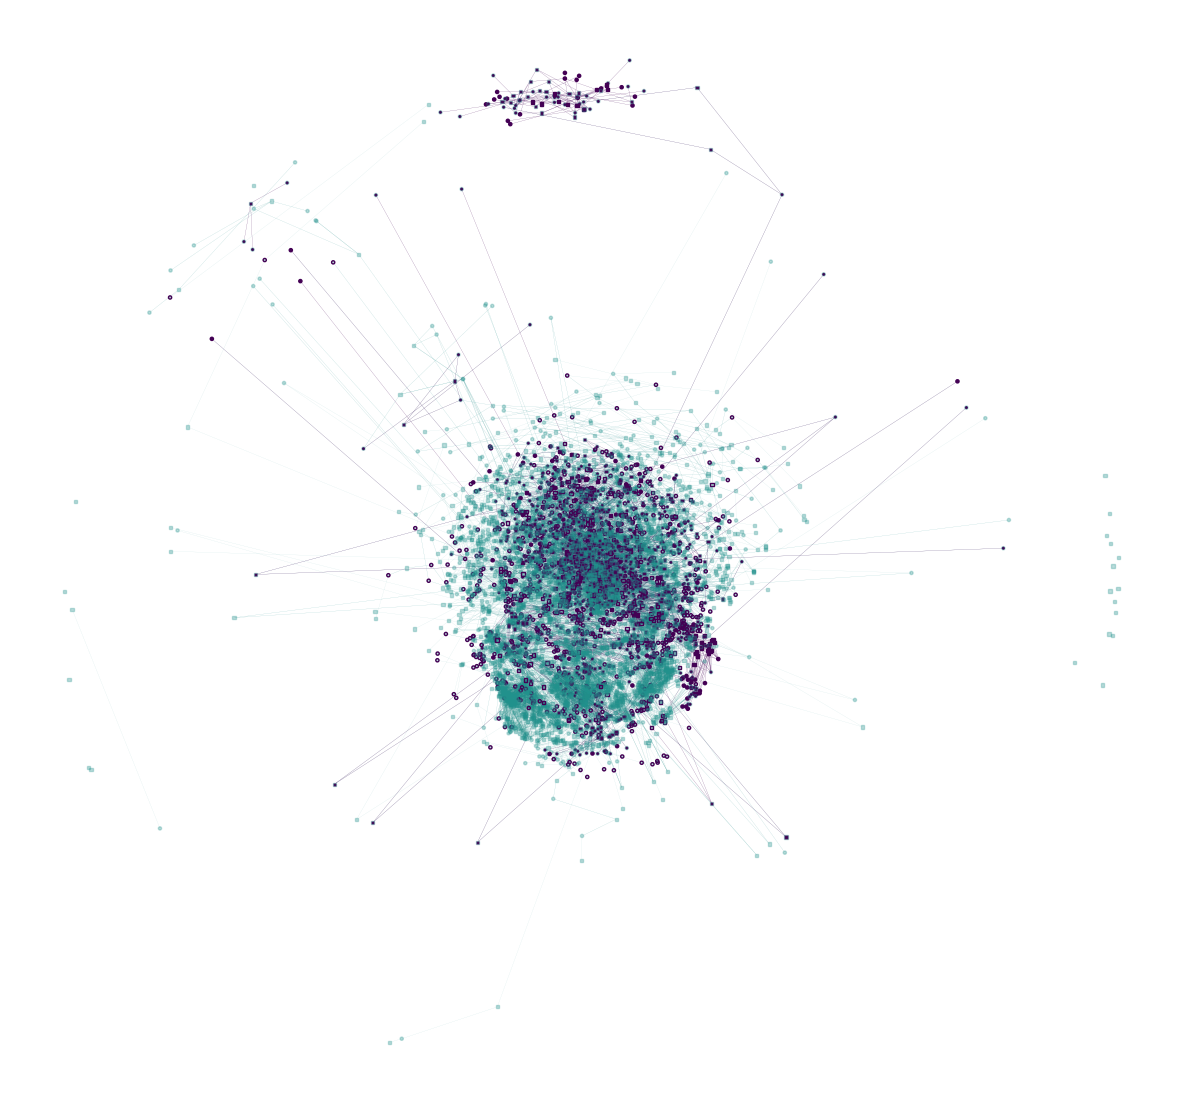

In [18]:

fig2, ax2 = plt.subplots(figsize=(15, 15)) 

# Plot the graph
ig.plot(
    graph,
    target=ax2,
    vertex_size=0.5,      
    edge_width=0.1,
    edge_color=graph.es['color'], 
    vertex_shape=graph.vs["shape"],
    edge_arrow_size=0.005,
    vertex_frame_color = graph.es['color'],
    layout=layout,
    vertex_label = None
)

plt.show()


In [19]:
# Save the graph_connected in GraphML format
graph.write("Yeast8_graph_directed_bipartite_revasdouble_filtHplush2o.graphml", format="graphml")


## Calculating what % of the metabolic network is coloured with metal anno or not anno based on graph

In [20]:
# Count the number of nodes colored with metalanno_color
colored_nodes_count = sum(1 for v in graph.vs if v['color'] == metalanno_color)
percent_colored_nodes = (colored_nodes_count / len(graph.vs)) * 100

# Count the number of edges colored with metalanno_color
colored_edges_count = sum(1 for e in graph.es if e['color'] == metalanno_color)
percent_colored_edges = (colored_edges_count / len(graph.es)) * 100

# Compute the number of nodes and edges colored with no_metalanno_color
no_metal_colored_nodes_count = len(graph.vs) - colored_nodes_count
no_metal_colored_edges_count = len(graph.es) - colored_edges_count

percent_no_metal_colored_nodes = (no_metal_colored_nodes_count / len(graph.vs)) * 100
percent_no_metal_colored_edges = (no_metal_colored_edges_count / len(graph.es)) * 100

print(f"Percentage of nodes colored with metalanno_color: {percent_colored_nodes:.2f}%")
print(f"Percentage of edges colored with metalanno_color: {percent_colored_edges:.2f}%")

print(f"Percentage of nodes colored with no_metalanno_color: {percent_no_metal_colored_nodes:.2f}%")
print(f"Percentage of edges colored with no_metalanno_color: {percent_no_metal_colored_edges:.2f}%")


Percentage of nodes colored with metalanno_color: 20.81%
Percentage of edges colored with metalanno_color: 10.93%
Percentage of nodes colored with no_metalanno_color: 79.19%
Percentage of edges colored with no_metalanno_color: 89.07%


### Checking % of bidrectional edges in graph

In [21]:
# Check if most edges are bidirectional
bidirectional_edges = sum(1 for e in graph.es if graph.are_connected(e.target, e.source))
total_edges = len(graph.es)
print(f"Bidirectional edges: {bidirectional_edges}/{total_edges} ({(bidirectional_edges / total_edges) * 100:.2f}%)")

# Check the degree distribution (in-degree and out-degree symmetry)
in_degrees = graph.degree(mode="IN")
out_degrees = graph.degree(mode="OUT")
print(f"Average in-degree: {sum(in_degrees) / len(in_degrees):.2f}")
print(f"Average out-degree: {sum(out_degrees) / len(out_degrees):.2f}")


Bidirectional edges: 9228/17574 (52.51%)
Average in-degree: 2.54
Average out-degree: 2.54


## Calculating connectedness of enzyme nodes

In [22]:
# Get degrees of all nodes
degrees = graph.degree()

# Extract degrees for reaction nodes only
reaction_degrees = [degrees[idx] for idx, name in enumerate(graph.vs["name"]) if name in reaction_to_index]


#### calculate betweenness

In [23]:
betweenness = graph.betweenness()


## Collect metal annotations of nodes

In [24]:
# Filter reactions based on their presence in the graph
metal_annotated_present = [r for r in metal_annotated_reactions if r.id in graph.vs["name"]]
non_metal_annotated_present = [r for r in non_metal_annotated_reactions if r.id in graph.vs["name"]]

# Extracting IDs from the reactions
metal_annotated_present_ids = [r.id for r in metal_annotated_present]
non_metal_annotated_present_ids = [r.id for r in non_metal_annotated_present]


In [25]:
orf_to_metal_list = metal_annotation_df.groupby('ORF')['term'].apply(list).to_dict()

reaction_to_orfs = {
    reaction.id: [gene.id for gene in reaction.genes] for reaction in model.reactions
}

reaction_to_metals = {
    reaction: set().union(*(orf_to_metal_list.get(orf, []) for orf in orfs))
    for reaction, orfs in reaction_to_orfs.items()
}

## Distance from(downstream) and to (upstream) nearest metal node

In [26]:
def compute_shortest_distances_from_metal(graph, source_nodes, target_nodes):
    """
    Compute the shortest distance from each metal-annotated node to each target node (reaction or metabolite).

    Parameters:
    - graph: the graph in which to calculate distances.
    - metal_nodes: list of metal-annotated node indices (source nodes).
    - target_nodes: list of target node indices (reaction or metabolite nodes).

    Returns:
    A dictionary where keys are target nodes and values are their respective shortest distances from any metal-annotated node.
    """
    shortest_distances_from_metal = {}

    for target in target_nodes:
        shortest_distance = float('inf')
        for source in source_nodes:
            try:
                path_length = graph.distances(source=source, target=target, mode='out')[0][0]
                if path_length < shortest_distance:
                    shortest_distance = path_length
            except:
                continue  # Ignore cases where no path exists
        # If no reachable path exists, distance remains 'inf'
        shortest_distances_from_metal[target] = shortest_distance

    return shortest_distances_from_metal

def compute_shortest_distances_to_metal(graph, source_nodes, target_nodes):
    """
    Compute the shortest distance from each target node (reaction or metabolite) to the nearest metal-annotated node.

    Parameters:
    - graph: the graph in which to calculate distances.
    - target_nodes: list of target node indices (reaction or metabolite nodes).
    - metal_nodes: list of metal-annotated node indices (target nodes).

    Returns:
    A dictionary where keys are target nodes and values are their respective shortest distances to the nearest metal-annotated node.
    """
    shortest_distances_to_metal = {}

    for source in source_nodes:
        shortest_distance = float('inf')
        for target in target_nodes:
            try:
                path_length = graph.distances(source=source, target=target, mode='out')[0][0]
                if path_length < shortest_distance:
                    shortest_distance = path_length
            except:
                continue  # Ignore cases where no path exists
        # If no reachable path exists, distance remains 'inf'
        shortest_distances_to_metal[source] = shortest_distance

    return shortest_distances_to_metal


def compute_statistics(distance_list):
    """
    Compute count and percentage statistics for each distance value.

    Parameters:
    - distance_list: A list of distance values.

    Returns:
    A dictionary where keys are distance values and values are dictionaries containing 'count', 'total', 'percentage'.
    """
    total_count = len(distance_list)
    distance_counts = Counter(distance_list)

    statistics = {}
    for distance, count in distance_counts.items():
        percentage = (count / total_count) * 100
        statistics[distance] = {
            "count": count,
            "total": total_count,
            "percentage": percentage
        }

    return statistics

#### Extract all reaction nodes and metal annotations

In [27]:
# Mapping from node names to node indices in the graph
node_name_to_index = {v["name"]: v.index for v in graph.vs}

# Extract reaction node names from the graph
reaction_nodes_filtered = [v["name"] for v in graph.vs if v["type"] == "reaction"]
reaction_indices_filtered = [node_name_to_index[name] for name in reaction_nodes_filtered if name in node_name_to_index]

# Extract metal-annotated and non-metal-annotated reaction nodes
# After verifying `metal_annotated_present_ids` and `non_metal_annotated_present_ids` contain correct reaction IDs
metal_annotated_nodes = set(metal_annotated_present_ids)
nometal_annotated_nodes = set(non_metal_annotated_present_ids)

# Map metal-annotated and non-metal-annotated reactions to graph node indices
metal_annotated_node_indices = [node_name_to_index[r] for r in metal_annotated_nodes if r in node_name_to_index]
nometal_annotated_node_indices = [node_name_to_index[r] for r in nometal_annotated_nodes if r in node_name_to_index]

# Print counts to verify correct node extraction
print(f"Total reaction nodes: {len(reaction_indices_filtered)}")
print(f"Metal-annotated reaction nodes: {len(metal_annotated_node_indices)}")
print(f"Non-metal-annotated reaction nodes: {len(nometal_annotated_node_indices)}")


Total reaction nodes: 4131
Metal-annotated reaction nodes: 556
Non-metal-annotated reaction nodes: 3575


### reactions

#### Downstream calculation (from metal nodes to all reaction nodes)

In [28]:
reaction_node_indices = [v.index for v in graph.vs if v['type'] == 'reaction']


In [29]:
# Calculate downstream distances (reaction -> metal reaction nodes)
downstream_distances_rxn_metal = compute_shortest_distances_to_metal(
    graph=graph,
    source_nodes=reaction_node_indices,
    target_nodes=metal_annotated_node_indices
)

#### Upstream calculation (from metal nodes to all reaction nodes)

In [30]:
# Calculate upstream distances (metal reaction nodes -> reaction)
upstream_distances_rxn_metal = compute_shortest_distances_from_metal(
    graph=graph,
    source_nodes=metal_annotated_node_indices,
    target_nodes=reaction_node_indices
)

In [31]:
# Compute statistics for downstream distances
downstream_distances_rxn_metals_list = list(downstream_distances_rxn_metal.values())
downstream_stats_rxn = compute_statistics(downstream_distances_rxn_metals_list)
df_downstream_summary_rxn = pd.DataFrame([
    {"Distance": distance, "Count": data['count'], "Total": data['total'], "Percentage": data['percentage'], "Direction": "downstream"}
    for distance, data in downstream_stats_rxn.items()
])

# Compute statistics for upstream distances
upstream_distances_rxn_metal_list = list(upstream_distances_rxn_metal.values())
upstream_stats_rxn = compute_statistics(upstream_distances_rxn_metal_list)
df_upstream_summary_rxn = pd.DataFrame([
    {"Distance": distance, "Count": data['count'], "Total": data['total'], "Percentage": data['percentage'], "Direction": "upstream"}
    for distance, data in upstream_stats_rxn.items()
])

# Combine summary statistics for both directions
df_summary_combined_rxn = pd.concat([df_downstream_summary_rxn, df_upstream_summary_rxn], ignore_index=True)


df_summary_combined_rxn.to_csv('distance_summary_from_nearest_metal_node_rxn_both_directions.csv', index=False)


In [32]:
df_downstream_summary_rxn.to_csv("distances_metalrxn2testrxn.csv")
df_upstream_summary_rxn.to_csv("distances_testrxn2metalrxn.csv")

In [33]:
df_summary_combined_rxn

,Distance,Count,Total,Percentage,Direction
0,0.0,556,4131,13.459211,downstream
1,2.0,1413,4131,34.204793,downstream
2,4.0,1050,4131,25.417574,downstream
3,inf,345,4131,8.351489,downstream
4,6.0,424,4131,10.263859,downstream
5,8.0,343,4131,8.303074,downstream
6,0.0,556,4131,13.459211,upstream
7,2.0,1310,4131,31.711450,upstream
8,4.0,1297,4131,31.396756,upstream
9,6.0,553,4131,13.386589,upstream


#### Plot distribution of nodes at each distance - upstream and downstream 

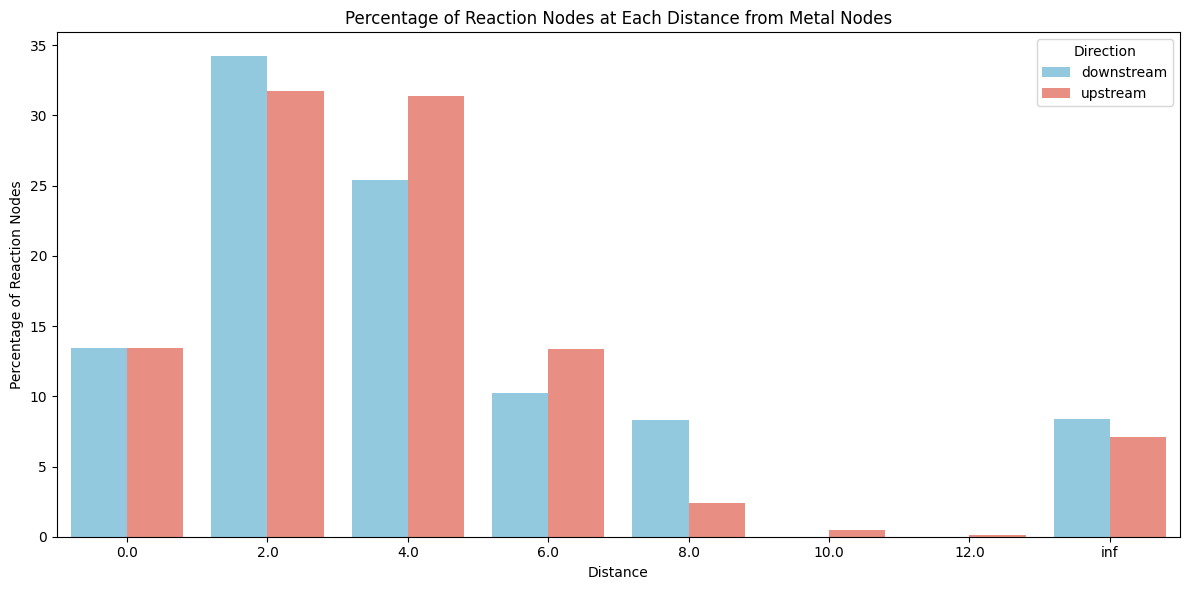

In [34]:
# Plotting
plt.figure(figsize=(12, 6))
palette = {'downstream': 'skyblue', 'upstream': 'salmon'}
sns.barplot(data=df_summary_combined_rxn, x='Distance', y='Percentage', hue='Direction', palette=palette)
plt.xlabel('Distance')
plt.ylabel('Percentage of Reaction Nodes')
plt.title('Percentage of Reaction Nodes at Each Distance from Metal Nodes')
plt.legend(title='Direction')
plt.tight_layout()

# Save plot to file
plt.savefig('distance_from_metalnode_rxns_both_directions.pdf', format='pdf', bbox_inches='tight')
plt.show()

## Randomly chosen metal nodes

In [35]:
# Number of iterations for random sampling
n_iterations = 100
random_summary_results = []

# Extract reaction node indices for random sampling
reaction_node_indices = [v.index for v in graph.vs if v['type'] == 'reaction']
n_metal_nodes = len(metal_annotated_node_indices)

# Perform random sampling and calculate distances for each iteration
for _ in range(n_iterations):
    # Randomly select nodes to act as "metal nodes"
    random_metal_nodes = random.sample(reaction_node_indices, n_metal_nodes)
    
    # Downstream distances (from random metal nodes to target reaction nodes)
    random_downstream_distances = compute_shortest_distances_from_metal(
        graph=graph,
        source_nodes=random_metal_nodes,
        target_nodes=reaction_node_indices
    )

    # Upstream distances (from target reaction nodes to random metal nodes)
    random_upstream_distances = compute_shortest_distances_to_metal(
        graph=graph,
        source_nodes=reaction_node_indices,
        target_nodes=random_metal_nodes
    )

    # Convert distances to lists for downstream and upstream
    downstream_distances_list = list(random_downstream_distances.values())
    upstream_distances_list = list(random_upstream_distances.values())

    # Compute statistics for downstream and upstream
    downstream_stats = compute_statistics(downstream_distances_list)
    upstream_stats = compute_statistics(upstream_distances_list)

    # Record results for this iteration
    for distance, data in downstream_stats.items():
        random_summary_results.append({
            "Distance": distance,
            "Count": data["count"],
            "Total": data["total"],
            "Percentage": data["percentage"],
            "Direction": "downstream",
            "Iteration": _
        })

    for distance, data in upstream_stats.items():
        random_summary_results.append({
            "Distance": distance,
            "Count": data["count"],
            "Total": data["total"],
            "Percentage": data["percentage"],
            "Direction": "upstream",
            "Iteration": _
        })

In [36]:
# Convert to DataFrame for analysis
df_random_summary = pd.DataFrame(random_summary_results)

# Calculate mean and standard deviation for each distance level across iterations
df_random_summary_stats = df_random_summary.groupby(["Distance", "Direction"]).agg(
    Mean_Percentage=("Percentage", "mean"),
    SD_Percentage=("Percentage", "std")
).reset_index()

# Save random summary statistics to CSV
df_random_summary_stats.to_csv('distances2random_bothdir_summary.csv', index=False)



/var/folders/vh/lnghn4t946vgw9lg4fwx6p6w0000gn/T/ipykernel_24914/3351393843.py:13: FutureWarning: This dataframe has a column name that matches the 'value_name' column name of the resulting Dataframe. In the future this will raise an error, please set the 'value_name' parameter of DataFrame.melt to a unique name.
  df_combined_melted = pd.melt(


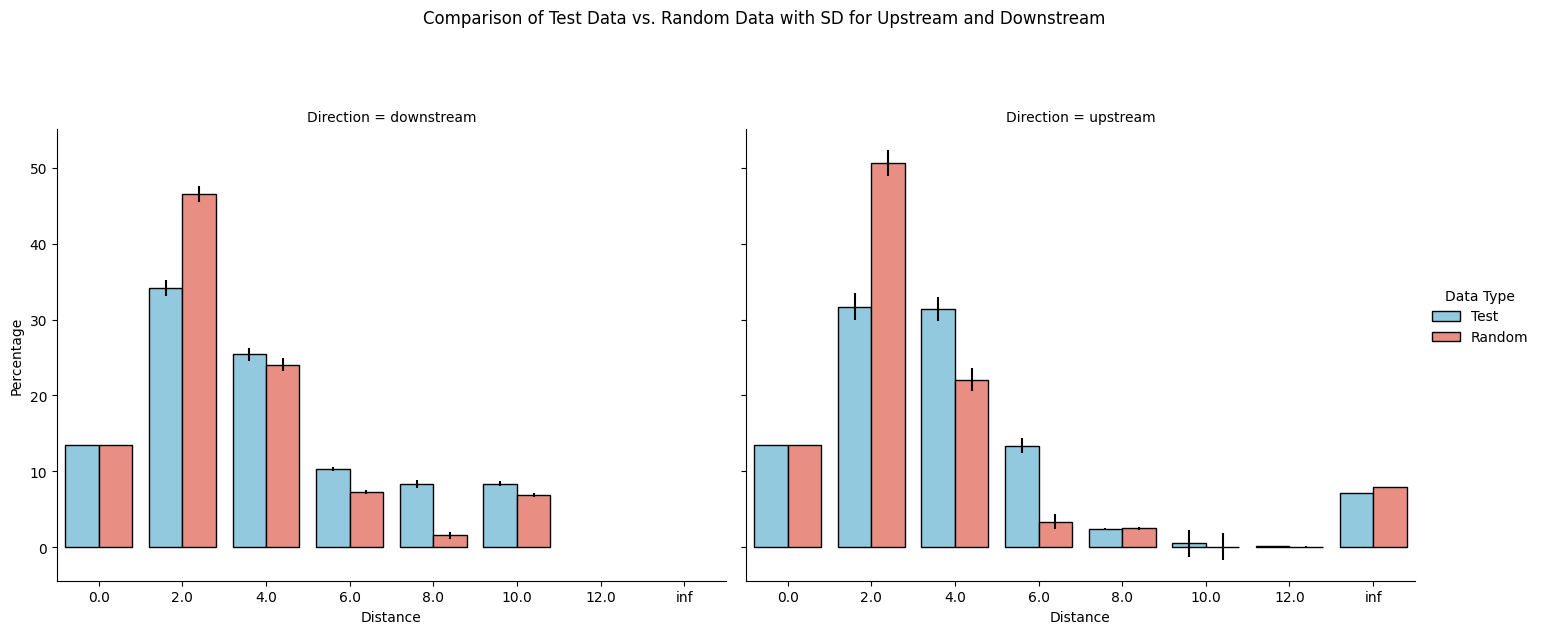

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Assume df_summary_combined is the test data and df_random_summary_stats is the random data
# Rename columns in df_random_summary_stats for clarity
df_random_summary_stats = df_random_summary_stats.rename(columns={'Mean_Percentage': 'Random_Mean', 'SD_Percentage': 'Random_SD'})

# Merge the test and random summary data on Distance and Direction
df_combined = pd.merge(df_summary_combined_rxn, df_random_summary_stats, on=['Distance', 'Direction'], how='left')

# Melt the DataFrame to have a single column for Percentage values and a Type column to distinguish Test and Random
df_combined_melted = pd.melt(
    df_combined,
    id_vars=['Distance', 'Direction', 'Random_SD'],  # Keep Random_SD as an id_var to access it directly
    value_vars=['Percentage', 'Random_Mean'],
    var_name='Type',
    value_name='Percentage'
)

# Update Type values to be more descriptive
df_combined_melted['Type'] = df_combined_melted['Type'].replace({'Percentage': 'Test', 'Random_Mean': 'Random'})

# Set up FacetGrid to create separate plots for 'upstream' and 'downstream'
g = sns.FacetGrid(df_combined_melted, col='Direction', sharey=True, height=6, aspect=1.2)

# Define color palette for test and random bars
palette = {'Test': 'skyblue', 'Random': 'salmon'}

# Custom plotting function to include error bars for random data
def plot_with_errorbars(data, **kwargs):
    sns.barplot(
        data=data,
        x='Distance',
        y='Percentage',
        hue='Type',
        palette=palette,
        edgecolor="black",
        yerr=data[data['Type'] == 'Random']['Random_SD'] if 'Random' in data['Type'].values else None,
        capsize=5,     # Increase cap size for error bars
        errwidth=10     # Make error bar lines thicker for visibility
    )

# Apply the plotting function to each facet
g.map_dataframe(plot_with_errorbars)

# Adjust plot labels and add a legend
g.set_axis_labels("Distance", "Percentage")
g.add_legend(title='Data Type')
g.fig.suptitle('Comparison of Test Data vs. Random Data with SD for Upstream and Downstream', y=1.05)
plt.subplots_adjust(top=0.85)
plt.show()


### metabolites

In [38]:
metabolite_node_indices = [v.index for v in graph.vs if v['type'] == 'metabolite']

# Calculate downstream distances (metabolite -> metal reaction nodes)
downstream_distances_metabolite_metal = compute_shortest_distances_to_metal(
    graph=graph,
    source_nodes=metabolite_node_indices,
    target_nodes=metal_annotated_node_indices
)

# Calculate upstream distances (metal reaction nodes -> metabolite)
upstream_distances_metabolite_metal = compute_shortest_distances_from_metal(
    graph=graph,
    source_nodes=metal_annotated_node_indices,
    target_nodes=metabolite_node_indices
)

In [39]:
downstream_distances_metabolite_metal_list = list(downstream_distances_metabolite_metal.values())
downstream_stats_metabolite = compute_statistics(downstream_distances_metabolite_metal_list)
df_downstream_summary_metabolite = pd.DataFrame([
    {"Distance": distance, "Count": data['count'], "Total": data['total'], "Percentage": data['percentage'], "Direction": "downstream"}
    for distance, data in downstream_stats_metabolite.items()
])

# Compute statistics for upstream distances
upstream_distances_metabolite_metal_list = list(upstream_distances_metabolite_metal.values())
upstream_stats_metabolite = compute_statistics(upstream_distances_metabolite_metal_list)
df_upstream_summary_metabolite = pd.DataFrame([
    {"Distance": distance, "Count": data['count'], "Total": data['total'], "Percentage": data['percentage'], "Direction": "upstream"}
    for distance, data in upstream_stats_metabolite.items()
])

In [40]:
df_downstream_summary_metabolite.to_csv("distances_metalrxn2metabolite.csv")

In [41]:
df_upstream_summary_metabolite.to_csv("distances_metabolite2metalrxn.csv")

## Summarise flux and enzyme changes at each distance of node

In [43]:
# Step 1: Load Significant ORFs for Flux, Cell, and Environment
flux_smry_filepath = "/Users/aulakhs/Documents/RalserLab/metallica/experiment_data/metpert_Yeast8simulation/output/tables/flux_change_detected_summary_per_metal.csv"
flux_summary = pd.read_csv(flux_smry_filepath)
significant_flux_orfs = flux_summary[flux_summary['flux_change_detected'] == True]['grRules'].unique()

# Load significant ORFs from proteomics (cell and environment)
cell_summary = pd.read_csv("DAproteins_cell_binary.csv")
env_summary = pd.read_csv("DAproteins_env_binary.csv")

significant_cell_orfs = cell_summary[cell_summary['Significant'] == True]['ORF'].unique()
significant_env_orfs = env_summary[env_summary['Significant'] == True]['ORF'].unique()


In [44]:
reaction_ORF_distance_data = {}

for reaction_id in reaction_to_orfs.keys():
    reaction_index = graph.vs.find(name=reaction_id).index

    # Downstream and upstream distances
    downstream_distance = downstream_distances_rxn_metal.get(reaction_index, float('inf'))
    upstream_distance = upstream_distances_rxn_metal.get(reaction_index, float('inf'))

    # Store ORFs and distances
    reaction_ORF_distance_data[reaction_id] = {
        'downstream_distance': downstream_distance,
        'upstream_distance': upstream_distance,
        'orfs': reaction_to_orfs[reaction_id]
    }

In [45]:
# Step 5: Annotate Reactions with Significant Flags Based on ORFs
for reaction_id, data in reaction_ORF_distance_data.items():
    data['flux_significant'] = any(orf in significant_flux_orfs for orf in data['orfs'])
    data['cell_significant'] = any(orf in significant_cell_orfs for orf in data['orfs'])
    data['env_significant'] = any(orf in significant_env_orfs for orf in data['orfs'])

# Convert to a DataFrame for further processing
distance_wise_sig = pd.DataFrame.from_dict(reaction_ORF_distance_data, orient='index')



In [46]:
distance_wise_sig

,downstream_distance,upstream_distance,orfs,flux_significant,cell_significant,env_significant
r_0001,0.0,0.0,"[YEL071W, YDL174C, YJR048W, YEL039C]",True,True,True
r_0002,0.0,0.0,"[YJR048W, YDL178W, YEL039C]",True,True,True
r_0003,0.0,0.0,[YAL060W],False,True,True
r_0004,0.0,0.0,"[YML054C, YJR048W, YEL039C]",True,False,False
r_0005,2.0,2.0,"[YPR165W, YMR306W, YLR342W, YGR032W]",True,True,True
...,...,...,...,...,...,...
r_4774,0.0,0.0,[YKL067W],True,True,True
r_4775,0.0,0.0,[YKL067W],True,True,True
r_4776,0.0,0.0,[YKL067W],True,True,True
r_4777,0.0,0.0,[YKL067W],True,True,True


In [47]:
def summarize_significant_by_distance(df, distance_column):
    """
    Summarize the fraction of significant reactions by distance.
    
    Parameters:
    - df: DataFrame containing distances and significance flags
    - distance_column: the column ('downstream_distance' or 'upstream_distance') to group by
    
    Returns:
    - DataFrame with summarized statistics
    """
    grouped_df = df.groupby(distance_column).agg(
        total_reactions=pd.NamedAgg(column='flux_significant', aggfunc='size'),
        flux_significant_count=pd.NamedAgg(column='flux_significant', aggfunc=lambda x: x.sum()),
        cell_significant_count=pd.NamedAgg(column='cell_significant', aggfunc=lambda x: x.sum()),
        env_significant_count=pd.NamedAgg(column='env_significant', aggfunc=lambda x: x.sum())
    )
    # Calculate fraction of significant reactions for each distance
    grouped_df['flux_fraction'] = grouped_df['flux_significant_count'] / grouped_df['total_reactions'] * 100
    grouped_df['cell_fraction'] = grouped_df['cell_significant_count'] / grouped_df['total_reactions'] * 100
    grouped_df['env_fraction'] = grouped_df['env_significant_count'] / grouped_df['total_reactions'] * 100
    return grouped_df

In [48]:
# Summarize for downstream distances
distance_wise_sig_df_downstream = summarize_significant_by_distance(distance_wise_sig, 'downstream_distance')

# Summarize for upstream distances
distance_wise_sig_df_upstream = summarize_significant_by_distance(distance_wise_sig, 'upstream_distance')


In [49]:
distance_wise_sig_df_downstream

,total_reactions,flux_significant_count,cell_significant_count,env_significant_count,flux_fraction,cell_fraction,env_fraction
downstream_distance,,,,,,,
0.0,556,149,281,212,26.798561,50.539568,38.129496
2.0,1413,243,329,276,17.197452,23.283793,19.532909
4.0,1050,173,222,217,16.476190,21.142857,20.666667
6.0,424,49,80,69,11.556604,18.867925,16.273585
8.0,343,1,22,22,0.291545,6.413994,6.413994
inf,345,4,2,0,1.159420,0.579710,0.000000


In [50]:
distance_wise_sig_df_upstream

,total_reactions,flux_significant_count,cell_significant_count,env_significant_count,flux_fraction,cell_fraction,env_fraction
upstream_distance,,,,,,,
0.0,556,149,281,212,26.798561,50.539568,38.129496
2.0,1310,248,339,302,18.931298,25.877863,23.053435
4.0,1297,167,214,195,12.875867,16.499614,15.034695
6.0,553,43,75,75,7.775769,13.562387,13.562387
8.0,98,1,2,1,1.020408,2.040816,1.020408
10.0,21,0,6,0,0.000000,28.571429,0.000000
12.0,4,0,0,0,0.000000,0.000000,0.000000
inf,292,11,19,11,3.767123,6.506849,3.767123


In [51]:
def plot_significance_by_distance(distance_df, direction_label):
    """
    Plot the fraction of significant reactions at each distance.
    
    Parameters:
    - distance_df: DataFrame containing the fraction of significant reactions by distance
    - direction_label: Label for the direction ('Upstream' or 'Downstream')
    """
    plt.figure(figsize=(10, 6))
    plt.plot(distance_df.index, distance_df['flux_fraction'], label='Flux Significant (%)', marker='o')
    plt.plot(distance_df.index, distance_df['cell_fraction'], label='Cell Significant (%)', marker='s')
    plt.plot(distance_df.index, distance_df['env_fraction'], label='Env Significant (%)', marker='^')
    
    plt.xlabel(f'{direction_label} Distance')
    plt.ylabel('Fraction of Significant Reactions (%)')
    plt.title(f'Fraction of Significant Reactions by {direction_label} Distance')
    plt.legend()
    plt.grid(True)
    plt.show()

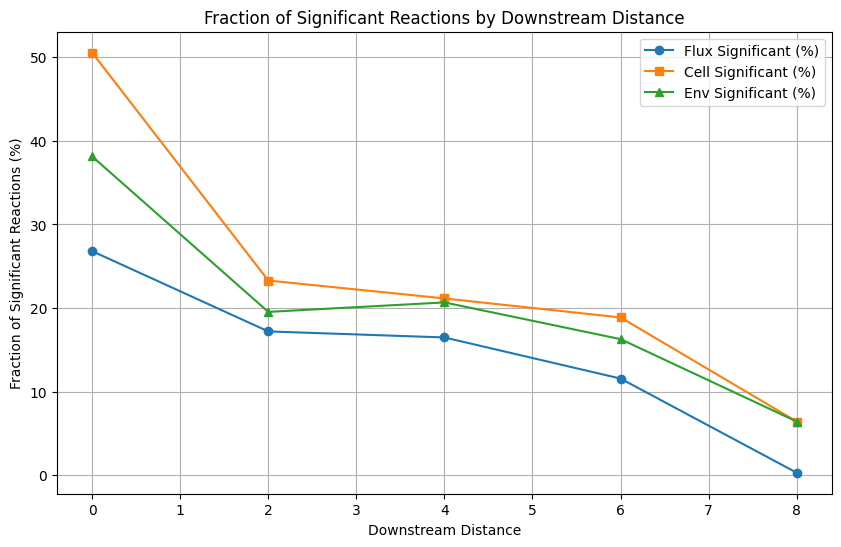

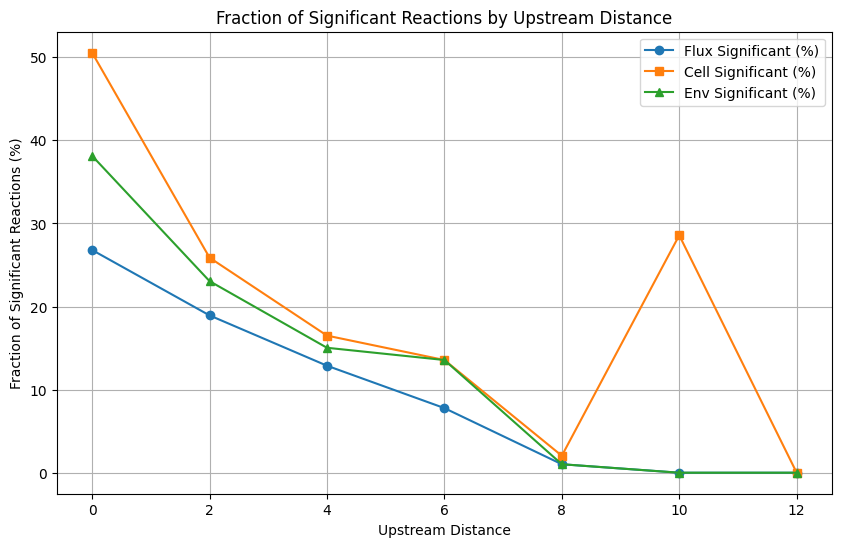

In [52]:
# Plot downstream significance
plot_significance_by_distance(distance_wise_sig_df_downstream, 'Downstream')

# Plot upstream significance
plot_significance_by_distance(distance_wise_sig_df_upstream, 'Upstream')


In [53]:
import matplotlib.pyplot as plt
import numpy as np

# Define darker colors based on the reference image
color_flux_darker = '#458B00'  # Darker green for significant flux change
color_env_darker = '#6A5ACD'   # Darker purple for environmental concentration
color_cell_darker = '#FF6347'  # Darker red for cellular concentration

def preprocess_distances(df):
    """Convert 'inf' values in the index to '14' for plotting purposes."""
    df = df.copy()
    df.index = np.where(df.index == np.inf, 14, df.index)  # Replace inf with 100 for numeric axis
    return df

def plot_combined_significance_by_distance(distance_df_downstream, distance_df_upstream):
    """
    Plot the fraction of significant reactions at each distance for both upstream and downstream,
    with total counts labeled. Handles 'inf' values by replacing them with '100' in the distance columns.
    
    Parameters:
    - distance_df_downstream: DataFrame for downstream distances
    - distance_df_upstream: DataFrame for upstream distances
    """
    # Preprocess distances to handle inf as 100
    distance_df_downstream = preprocess_distances(distance_df_downstream)
    distance_df_upstream = preprocess_distances(distance_df_upstream)

    plt.figure(figsize=(10, 6))

    # Plot downstream data with solid lines
    plt.plot(distance_df_downstream.index, distance_df_downstream['flux_fraction'], label='Flux Significant (Downstream)', color=color_flux_darker, marker='o', linestyle='-')
    plt.plot(distance_df_downstream.index, distance_df_downstream['cell_fraction'], label='Cell Significant (Downstream)', color=color_cell_darker, marker='s', linestyle='-')
    plt.plot(distance_df_downstream.index, distance_df_downstream['env_fraction'], label='Env Significant (Downstream)', color=color_env_darker, marker='^', linestyle='-')

    # Plot upstream data with dashed lines
    plt.plot(distance_df_upstream.index, distance_df_upstream['flux_fraction'], label='Flux Significant (Upstream)', color=color_flux_darker, marker='o', linestyle='--')
    plt.plot(distance_df_upstream.index, distance_df_upstream['cell_fraction'], label='Cell Significant (Upstream)', color=color_cell_darker, marker='s', linestyle='--')
    plt.plot(distance_df_upstream.index, distance_df_upstream['env_fraction'], label='Env Significant (Upstream)', color=color_env_darker, marker='^', linestyle='--')
    
    # Add labels for the total count (N) on each point in black
    for distance, row in distance_df_downstream.iterrows():
        plt.text(distance, row['flux_fraction'], f"N={row['total_reactions']}", ha='center', va='bottom', fontsize=9, color='black')
    for distance, row in distance_df_upstream.iterrows():
        plt.text(distance, row['flux_fraction'], f"N={row['total_reactions']}", ha='center', va='top', fontsize=9, color='black')

    # Set x-ticks as sorted numeric distances, including 100 at the end
    all_distances = sorted(set(distance_df_downstream.index).union(set(distance_df_upstream.index)), key=float)
    plt.xticks(all_distances)

    # Labeling and legend
    plt.xlabel('Distance')
    plt.ylabel('Fraction of Significant Reactions (%)')
    plt.title('Fraction of Significant Reactions by Distance (Upstream and Downstream)')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    # Save plot to PDF
    plt.savefig('distance_wise_perc_sign_rxn_upstream_downstream.pdf', format='pdf', bbox_inches='tight')
    plt.show()


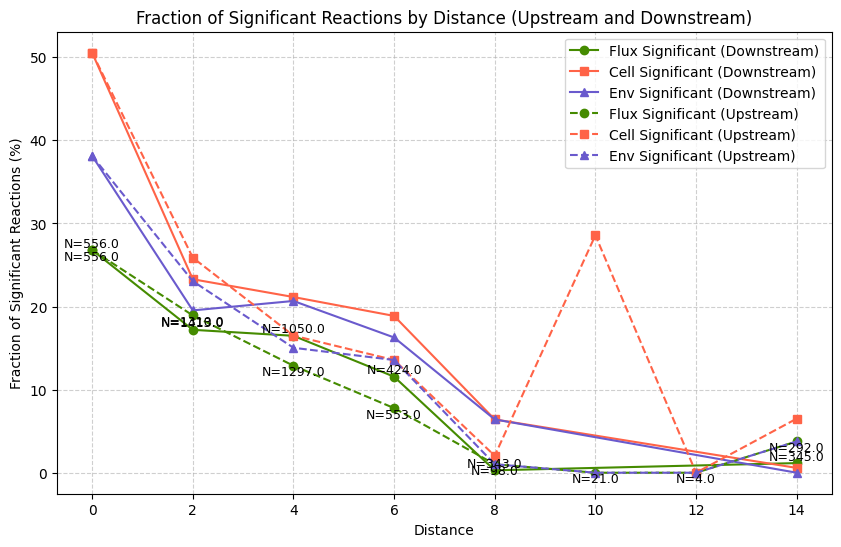

In [54]:
# Call the function and save the plot
plot_combined_significance_by_distance(distance_wise_sig_df_downstream, distance_wise_sig_df_upstream)
